**Baseline model + GAN (Generative adversarial network)**

In [ ]:
#from google.colab import drive
#import os
#drive.mount('/content/drive/')
#os.chdir('/content/drive/My Drive/Data/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from matplotlib import pyplot
import argparse
import os, os.path
import progressbar
from PIL import Image
import time


*Apply Generative adversarial network to create more images*

In [ ]:
initialWeights = RandomNormal(mean=0.0, stddev=0.02, seed=None)

In [ ]:
def define_discriminator(in_shape=(128,128,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape, kernel_initializer=initialWeights))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=initialWeights))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=initialWeights))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=initialWeights))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=initialWeights))
	model.add(BatchNormalization())
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(Reshape((4, 4, 256)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
	model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
	return model

In [ ]:
def define_gan(g_model, d_model):
 d_model.trainable = False
 model = Sequential()
 model.add(g_model)
 model.add(d_model)
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model

In [ ]:
from tqdm import tqdm
import cv2
labels = ['Mild_Demented']

X_train = [] #Training Dataset
image_size=128

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j),cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)

Xtrain = np.array(X_train)


100%|██████████| 716/716 [00:01<00:00, 495.21it/s]


In [ ]:
Xtrain.shape

(716, 128, 128)

*Original Image*

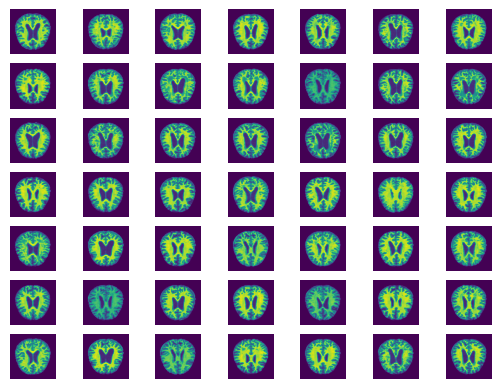

In [ ]:

from matplotlib import pyplot


for i in range(49):
 pyplot.subplot(7, 7, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(Xtrain[i])
pyplot.show()

In [ ]:

def load_real_samples():

 X = expand_dims(Xtrain, axis=-1)
 X = X.astype('float32')
 X = X / 255.0
 return X

In [ ]:
X.shape

(716, 128, 128, 1)

In [ ]:

def generate_real_samples(dataset, n_samples):

 ix = randint(0, dataset.shape[0], n_samples)
 X = dataset[ix]
 y = ones((n_samples, 1))
 return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
 x_input = randn(latent_dim * n_samples)
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
 x_input = generate_latent_points(latent_dim, n_samples)
 X = g_model.predict(x_input)
 y = zeros((n_samples, 1))
 return X, y


In [ ]:
def save_plot(examples, epoch, n=10):
 for i in range(n * n):
   pyplot.subplot(n, n, 1 + i)
   pyplot.axis('off')
   pyplot.imshow(examples[i, :, :, 0], cmap='gray')
   filename = 'Gray_generated_plot_e%03d.png' % (epoch+1)
   pyplot.savefig('/content/drive/My Drive/Data/Research/Process_2/output/' + filename)
   pyplot.close()

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=500):
 X_real, y_real = generate_real_samples(dataset, n_samples)
 _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
 x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
 _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
 print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
 save_plot(x_fake, epoch)
 filename = 'Gray_generator_model_%03d.h5' % (epoch + 1)
 g_model.save('/content/drive/My Drive/Data/Research/Process_2/output/' + filename)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=256):
 bat_per_epo = int(dataset.shape[0] / n_batch)
 half_batch = int(n_batch / 2)
 for i in range(n_epochs):
   for j in range(bat_per_epo):
     X_real, y_real = generate_real_samples(dataset, half_batch)
     X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
     X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
     d_loss, _ = d_model.train_on_batch(X, y)
     X_gan = generate_latent_points(latent_dim, n_batch)
     y_gan = ones((n_batch, 1))
     g_loss = gan_model.train_on_batch(X_gan, y_gan)
     print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
     if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [ ]:

latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)


dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 62ms/step
>1, 1/2, d=1.622, g=0.692
4/4 [==============================] - 0s 42ms/step
>1, 2/2, d=0.235, g=0.693
4/4 [==============================] - 0s 42ms/step
>2, 1/2, d=0.096, g=0.694
4/4 [==============================] - 0s 41ms/step
>2, 2/2, d=0.048, g=0.696
4/4 [==============================] - 0s 41ms/step
>3, 1/2, d=0.031, g=0.698
4/4 [==============================] - 0s 41ms/step
>3, 2/2, d=0.023, g=0.700
4/4 [==============================] - 0s 42ms/step
>4, 1/2, d=0.017, g=0.702
4/4 [==============================] - 0s 42ms/step
>4, 2/2, d=0.015, g=0.704
4/4 [==============================] - 0s 41ms/step
>5, 1/2, d=0.013, g=0.706
4/4 [==============================] - 0s 42ms/step
>5, 2/2, d=0.011, g=0.708
4/4 [==============================] - 0s 42ms/step
>6, 1/2, d=0.011, g=0.710
4/4 [==============================] - 0s 42ms/step
>6, 2/2, d=0.011, g=0.712
4/4 [==============================] - 0s 42ms/step
>7, 1/2, d=0

4/4 [==============================] - 0s 62ms/step
>10, 2/2, d=0.063, g=0.737
16/16 [==============================] - 1s 44ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 61ms/step
>11, 1/2, d=0.013, g=0.742
4/4 [==============================] - 0s 41ms/step
>11, 2/2, d=0.004, g=0.745
4/4 [==============================] - 0s 42ms/step
>12, 1/2, d=0.003, g=0.746
4/4 [==============================] - 0s 42ms/step
>12, 2/2, d=0.002, g=0.748
4/4 [==============================] - 0s 41ms/step
>13, 1/2, d=0.002, g=0.749
4/4 [==============================] - 0s 41ms/step
>13, 2/2, d=0.002, g=0.749
4/4 [==============================] - 0s 41ms/step
>14, 1/2, d=0.002, g=0.749
4/4 [==============================] - 0s 41ms/step
>14, 2/2, d=0.002, g=0.749
4/4 [==============================] - 0s 42ms/step
>15, 1/2, d=0.009, g=0.749
4/4 [==============================] - 0s 42ms/step
>15, 2/2, d=0.134, g=0.753
4/4 [==============================] - 0s 42ms/step
>16, 1/2, d=0.065, g=0.755
4/4 [==============================] - 0s 42ms/step
>16, 2/2, d=0.029, g=0.756
4/4 [==============================] - 0s 41ms/step


4/4 [==============================] - 0s 62ms/step
>20, 2/2, d=0.016, g=0.780
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>21, 1/2, d=0.023, g=0.784
4/4 [==============================] - 0s 41ms/step
>21, 2/2, d=0.034, g=0.789
4/4 [==============================] - 0s 41ms/step
>22, 1/2, d=0.044, g=0.793
4/4 [==============================] - 0s 41ms/step
>22, 2/2, d=0.033, g=0.798
4/4 [==============================] - 0s 41ms/step
>23, 1/2, d=0.017, g=0.801
4/4 [==============================] - 0s 41ms/step
>23, 2/2, d=0.007, g=0.804
4/4 [==============================] - 0s 42ms/step
>24, 1/2, d=0.006, g=0.805
4/4 [==============================] - 0s 41ms/step
>24, 2/2, d=0.014, g=0.807
4/4 [==============================] - 0s 42ms/step
>25, 1/2, d=0.008, g=0.811
4/4 [==============================] - 0s 41ms/step
>25, 2/2, d=0.002, g=0.815
4/4 [==============================] - 0s 42ms/step
>26, 1/2, d=0.001, g=0.818
4/4 [==============================] - 0s 42ms/step
>26, 2/2, d=0.002, g=0.820
4/4 [==============================] - 0s 42ms/step


4/4 [==============================] - 0s 62ms/step
>30, 2/2, d=0.001, g=0.862
16/16 [==============================] - 1s 44ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>31, 1/2, d=0.001, g=0.865
4/4 [==============================] - 0s 41ms/step
>31, 2/2, d=0.001, g=0.869
4/4 [==============================] - 0s 41ms/step
>32, 1/2, d=0.001, g=0.872
4/4 [==============================] - 0s 41ms/step
>32, 2/2, d=0.001, g=0.876
4/4 [==============================] - 0s 41ms/step
>33, 1/2, d=0.001, g=0.880
4/4 [==============================] - 0s 41ms/step
>33, 2/2, d=0.001, g=0.885
4/4 [==============================] - 0s 41ms/step
>34, 1/2, d=0.002, g=0.890
4/4 [==============================] - 0s 42ms/step
>34, 2/2, d=0.001, g=0.896
4/4 [==============================] - 0s 42ms/step
>35, 1/2, d=0.003, g=0.902
4/4 [==============================] - 0s 42ms/step
>35, 2/2, d=0.002, g=0.908
4/4 [==============================] - 0s 41ms/step
>36, 1/2, d=0.002, g=0.914
4/4 [==============================] - 0s 42ms/step
>36, 2/2, d=0.002, g=0.921
4/4 [==============================] - 0s 42ms/step


4/4 [==============================] - 0s 62ms/step
>40, 2/2, d=0.002, g=0.979
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 57ms/step
>41, 1/2, d=0.002, g=0.987
4/4 [==============================] - 0s 41ms/step
>41, 2/2, d=0.001, g=0.997
4/4 [==============================] - 0s 41ms/step
>42, 1/2, d=0.002, g=1.005
4/4 [==============================] - 0s 41ms/step
>42, 2/2, d=0.002, g=1.012
4/4 [==============================] - 0s 42ms/step
>43, 1/2, d=0.001, g=1.020
4/4 [==============================] - 0s 41ms/step
>43, 2/2, d=0.002, g=1.029
4/4 [==============================] - 0s 41ms/step
>44, 1/2, d=0.002, g=1.039
4/4 [==============================] - 0s 42ms/step
>44, 2/2, d=0.003, g=1.050
4/4 [==============================] - 0s 41ms/step
>45, 1/2, d=0.002, g=1.061
4/4 [==============================] - 0s 41ms/step
>45, 2/2, d=0.003, g=1.072
4/4 [==============================] - 0s 42ms/step
>46, 1/2, d=0.002, g=1.083
4/4 [==============================] - 0s 42ms/step
>46, 2/2, d=0.002, g=1.094
4/4 [==============================] - 0s 42ms/step


4/4 [==============================] - 0s 57ms/step
>50, 2/2, d=0.001, g=1.166
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 59ms/step
>51, 1/2, d=0.002, g=1.174
4/4 [==============================] - 0s 42ms/step
>51, 2/2, d=0.002, g=1.183
4/4 [==============================] - 0s 42ms/step
>52, 1/2, d=0.002, g=1.195
4/4 [==============================] - 0s 41ms/step
>52, 2/2, d=0.001, g=1.211
4/4 [==============================] - 0s 42ms/step
>53, 1/2, d=0.000, g=1.233
4/4 [==============================] - 0s 41ms/step
>53, 2/2, d=0.000, g=1.226
4/4 [==============================] - 0s 41ms/step
>54, 1/2, d=0.000, g=1.235
4/4 [==============================] - 0s 41ms/step
>54, 2/2, d=0.001, g=1.240
4/4 [==============================] - 0s 42ms/step
>55, 1/2, d=0.001, g=1.247
4/4 [==============================] - 0s 42ms/step
>55, 2/2, d=0.002, g=1.257
4/4 [==============================] - 0s 42ms/step
>56, 1/2, d=0.001, g=1.270
4/4 [==============================] - 0s 42ms/step
>56, 2/2, d=0.001, g=1.283
4/4 [==============================] - 0s 42ms/step


4/4 [==============================] - 0s 62ms/step
>60, 2/2, d=0.002, g=1.353
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>61, 1/2, d=0.001, g=1.364
4/4 [==============================] - 0s 41ms/step
>61, 2/2, d=0.002, g=1.374
4/4 [==============================] - 0s 41ms/step
>62, 1/2, d=0.001, g=1.390
4/4 [==============================] - 0s 41ms/step
>62, 2/2, d=0.000, g=1.426
4/4 [==============================] - 0s 41ms/step
>63, 1/2, d=0.000, g=1.417
4/4 [==============================] - 0s 41ms/step
>63, 2/2, d=0.001, g=1.415
4/4 [==============================] - 0s 41ms/step
>64, 1/2, d=0.001, g=1.424
4/4 [==============================] - 0s 42ms/step
>64, 2/2, d=0.001, g=1.434
4/4 [==============================] - 0s 41ms/step
>65, 1/2, d=0.001, g=1.449
4/4 [==============================] - 0s 41ms/step
>65, 2/2, d=0.000, g=1.471
4/4 [==============================] - 0s 41ms/step
>66, 1/2, d=0.000, g=1.486
4/4 [==============================] - 0s 42ms/step
>66, 2/2, d=0.000, g=1.488
4/4 [==============================] - 0s 42ms/step


4/4 [==============================] - 0s 56ms/step
>70, 2/2, d=0.001, g=1.575
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>71, 1/2, d=0.001, g=1.585
4/4 [==============================] - 0s 41ms/step
>71, 2/2, d=0.001, g=1.596
4/4 [==============================] - 0s 41ms/step
>72, 1/2, d=0.001, g=1.620
4/4 [==============================] - 0s 41ms/step
>72, 2/2, d=0.000, g=1.637
4/4 [==============================] - 0s 41ms/step
>73, 1/2, d=0.000, g=1.653
4/4 [==============================] - 0s 41ms/step
>73, 2/2, d=0.000, g=1.645
4/4 [==============================] - 0s 41ms/step
>74, 1/2, d=0.000, g=1.660
4/4 [==============================] - 0s 41ms/step
>74, 2/2, d=0.001, g=1.661
4/4 [==============================] - 0s 42ms/step
>75, 1/2, d=0.001, g=1.679
4/4 [==============================] - 0s 42ms/step
>75, 2/2, d=0.001, g=1.694
4/4 [==============================] - 0s 42ms/step
>76, 1/2, d=0.000, g=1.712
4/4 [==============================] - 0s 42ms/step
>76, 2/2, d=0.001, g=1.726
4/4 [==============================] - 0s 42ms/step


4/4 [==============================] - 0s 62ms/step
>80, 2/2, d=0.000, g=1.815
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 57ms/step
>81, 1/2, d=0.000, g=1.838
4/4 [==============================] - 0s 41ms/step
>81, 2/2, d=0.000, g=1.837
4/4 [==============================] - 0s 41ms/step
>82, 1/2, d=0.001, g=1.835
4/4 [==============================] - 0s 42ms/step
>82, 2/2, d=0.001, g=1.847
4/4 [==============================] - 0s 41ms/step
>83, 1/2, d=0.001, g=1.866
4/4 [==============================] - 0s 42ms/step
>83, 2/2, d=0.001, g=1.892
4/4 [==============================] - 0s 42ms/step
>84, 1/2, d=0.000, g=1.966
4/4 [==============================] - 0s 42ms/step
>84, 2/2, d=0.000, g=1.905
4/4 [==============================] - 0s 41ms/step
>85, 1/2, d=0.001, g=1.919
4/4 [==============================] - 0s 41ms/step
>85, 2/2, d=0.000, g=1.957
4/4 [==============================] - 0s 42ms/step
>86, 1/2, d=0.001, g=1.933
4/4 [==============================] - 0s 42ms/step
>86, 2/2, d=0.001, g=1.944
4/4 [==============================] - 0s 42ms/step


4/4 [==============================] - 0s 58ms/step
>90, 2/2, d=0.000, g=2.088
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 58ms/step
>91, 1/2, d=0.000, g=2.111
4/4 [==============================] - 0s 41ms/step
>91, 2/2, d=0.000, g=2.077
4/4 [==============================] - 0s 41ms/step
>92, 1/2, d=0.000, g=2.076
4/4 [==============================] - 0s 41ms/step
>92, 2/2, d=0.001, g=2.073
4/4 [==============================] - 0s 41ms/step
>93, 1/2, d=0.001, g=2.083
4/4 [==============================] - 0s 42ms/step
>93, 2/2, d=0.001, g=2.100
4/4 [==============================] - 0s 42ms/step
>94, 1/2, d=0.000, g=2.138
4/4 [==============================] - 0s 42ms/step
>94, 2/2, d=0.000, g=2.157
4/4 [==============================] - 0s 41ms/step
>95, 1/2, d=0.000, g=2.186
4/4 [==============================] - 0s 41ms/step
>95, 2/2, d=0.000, g=2.148
4/4 [==============================] - 0s 42ms/step
>96, 1/2, d=0.001, g=2.152
4/4 [==============================] - 0s 42ms/step
>96, 2/2, d=0.001, g=2.157
4/4 [==============================] - 0s 42ms/step


4/4 [==============================] - 0s 59ms/step
>100, 2/2, d=0.000, g=2.344
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 59ms/step
>101, 1/2, d=0.000, g=2.369
4/4 [==============================] - 0s 41ms/step
>101, 2/2, d=0.000, g=2.302
4/4 [==============================] - 0s 41ms/step
>102, 1/2, d=0.000, g=2.281
4/4 [==============================] - 0s 41ms/step
>102, 2/2, d=0.001, g=2.286
4/4 [==============================] - 0s 42ms/step
>103, 1/2, d=0.001, g=2.289
4/4 [==============================] - 0s 41ms/step
>103, 2/2, d=0.001, g=2.302
4/4 [==============================] - 0s 41ms/step
>104, 1/2, d=0.001, g=2.314
4/4 [==============================] - 0s 42ms/step
>104, 2/2, d=0.001, g=2.330
4/4 [==============================] - 0s 41ms/step
>105, 1/2, d=0.001, g=2.354
4/4 [==============================] - 0s 42ms/step
>105, 2/2, d=0.000, g=2.406
4/4 [==============================] - 0s 42ms/step
>106, 1/2, d=0.000, g=2.478
4/4 [==============================] - 0s 41ms/step
>106, 2/2, d=0.000, g=2.549
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>110, 2/2, d=0.001, g=2.441
16/16 [==============================] - 1s 44ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>111, 1/2, d=0.001, g=2.465
4/4 [==============================] - 0s 41ms/step
>111, 2/2, d=0.000, g=2.507
4/4 [==============================] - 0s 41ms/step
>112, 1/2, d=0.000, g=2.511
4/4 [==============================] - 0s 41ms/step
>112, 2/2, d=0.000, g=2.518
4/4 [==============================] - 0s 41ms/step
>113, 1/2, d=0.000, g=2.527
4/4 [==============================] - 0s 41ms/step
>113, 2/2, d=0.000, g=2.535
4/4 [==============================] - 0s 42ms/step
>114, 1/2, d=0.000, g=2.550
4/4 [==============================] - 0s 41ms/step
>114, 2/2, d=0.001, g=2.532
4/4 [==============================] - 0s 42ms/step
>115, 1/2, d=0.001, g=2.538
4/4 [==============================] - 0s 42ms/step
>115, 2/2, d=0.001, g=2.555
4/4 [==============================] - 0s 41ms/step
>116, 1/2, d=0.001, g=2.563
4/4 [==============================] - 0s 42ms/step
>116, 2/2, d=0.001, g=2.573
4/4 [==============================] - 0

4/4 [==============================] - 0s 61ms/step
>120, 2/2, d=0.000, g=2.673
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>121, 1/2, d=0.000, g=2.662
4/4 [==============================] - 0s 41ms/step
>121, 2/2, d=0.000, g=2.671
4/4 [==============================] - 0s 41ms/step
>122, 1/2, d=0.000, g=2.691
4/4 [==============================] - 0s 41ms/step
>122, 2/2, d=0.000, g=2.766
4/4 [==============================] - 0s 41ms/step
>123, 1/2, d=0.000, g=2.807
4/4 [==============================] - 0s 41ms/step
>123, 2/2, d=0.000, g=2.734
4/4 [==============================] - 0s 42ms/step
>124, 1/2, d=0.000, g=2.735
4/4 [==============================] - 0s 42ms/step
>124, 2/2, d=0.000, g=2.691
4/4 [==============================] - 0s 41ms/step
>125, 1/2, d=0.001, g=2.700
4/4 [==============================] - 0s 42ms/step
>125, 2/2, d=0.000, g=2.703
4/4 [==============================] - 0s 41ms/step
>126, 1/2, d=0.001, g=2.725
4/4 [==============================] - 0s 42ms/step
>126, 2/2, d=0.000, g=2.746
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>130, 2/2, d=0.000, g=2.902
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>131, 1/2, d=0.000, g=2.876
4/4 [==============================] - 0s 41ms/step
>131, 2/2, d=0.000, g=2.846
4/4 [==============================] - 0s 41ms/step
>132, 1/2, d=0.000, g=2.836
4/4 [==============================] - 0s 41ms/step
>132, 2/2, d=0.000, g=2.845
4/4 [==============================] - 0s 41ms/step
>133, 1/2, d=0.000, g=2.843
4/4 [==============================] - 0s 41ms/step
>133, 2/2, d=0.000, g=2.849
4/4 [==============================] - 0s 41ms/step
>134, 1/2, d=0.000, g=2.855
4/4 [==============================] - 0s 41ms/step
>134, 2/2, d=0.000, g=2.865
4/4 [==============================] - 0s 41ms/step
>135, 1/2, d=0.000, g=2.874
4/4 [==============================] - 0s 42ms/step
>135, 2/2, d=0.000, g=2.884
4/4 [==============================] - 0s 42ms/step
>136, 1/2, d=0.000, g=2.897
4/4 [==============================] - 0s 41ms/step
>136, 2/2, d=0.000, g=2.912
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>140, 2/2, d=0.000, g=2.999
16/16 [==============================] - 1s 44ms/step
>Accuracy real: 0%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>141, 1/2, d=0.000, g=3.012
4/4 [==============================] - 0s 41ms/step
>141, 2/2, d=0.000, g=3.028
4/4 [==============================] - 0s 41ms/step
>142, 1/2, d=0.000, g=3.046
4/4 [==============================] - 0s 41ms/step
>142, 2/2, d=0.000, g=3.040
4/4 [==============================] - 0s 42ms/step
>143, 1/2, d=0.000, g=3.008
4/4 [==============================] - 0s 42ms/step
>143, 2/2, d=0.000, g=2.990
4/4 [==============================] - 0s 41ms/step
>144, 1/2, d=0.000, g=2.991
4/4 [==============================] - 0s 42ms/step
>144, 2/2, d=0.000, g=2.986
4/4 [==============================] - 0s 42ms/step
>145, 1/2, d=0.000, g=2.990
4/4 [==============================] - 0s 42ms/step
>145, 2/2, d=0.000, g=3.002
4/4 [==============================] - 0s 42ms/step
>146, 1/2, d=0.000, g=3.017
4/4 [==============================] - 0s 42ms/step
>146, 2/2, d=0.000, g=3.021
4/4 [==============================] - 0

4/4 [==============================] - 0s 57ms/step
>150, 2/2, d=0.000, g=3.234
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 75%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>151, 1/2, d=0.000, g=3.258
4/4 [==============================] - 0s 41ms/step
>151, 2/2, d=0.000, g=3.176
4/4 [==============================] - 0s 41ms/step
>152, 1/2, d=0.000, g=3.176
4/4 [==============================] - 0s 41ms/step
>152, 2/2, d=0.000, g=3.119
4/4 [==============================] - 0s 41ms/step
>153, 1/2, d=0.000, g=3.110
4/4 [==============================] - 0s 42ms/step
>153, 2/2, d=0.000, g=3.106
4/4 [==============================] - 0s 42ms/step
>154, 1/2, d=0.000, g=3.100
4/4 [==============================] - 0s 42ms/step
>154, 2/2, d=0.000, g=3.114
4/4 [==============================] - 0s 41ms/step
>155, 1/2, d=0.000, g=3.124
4/4 [==============================] - 0s 43ms/step
>155, 2/2, d=0.000, g=3.140
4/4 [==============================] - 0s 42ms/step
>156, 1/2, d=0.000, g=3.156
4/4 [==============================] - 0s 41ms/step
>156, 2/2, d=0.000, g=3.170
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>160, 2/2, d=0.000, g=3.306
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>161, 1/2, d=0.000, g=3.287
4/4 [==============================] - 0s 41ms/step
>161, 2/2, d=0.000, g=3.290
4/4 [==============================] - 0s 41ms/step
>162, 1/2, d=0.000, g=3.274
4/4 [==============================] - 0s 41ms/step
>162, 2/2, d=0.000, g=3.271
4/4 [==============================] - 0s 42ms/step
>163, 1/2, d=0.000, g=3.276
4/4 [==============================] - 0s 42ms/step
>163, 2/2, d=0.000, g=3.299
4/4 [==============================] - 0s 41ms/step
>164, 1/2, d=0.000, g=3.330
4/4 [==============================] - 0s 41ms/step
>164, 2/2, d=0.000, g=3.330
4/4 [==============================] - 0s 42ms/step
>165, 1/2, d=0.000, g=3.326
4/4 [==============================] - 0s 41ms/step
>165, 2/2, d=0.000, g=3.337
4/4 [==============================] - 0s 42ms/step
>166, 1/2, d=0.000, g=3.342
4/4 [==============================] - 0s 42ms/step
>166, 2/2, d=0.000, g=3.345
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>170, 2/2, d=0.000, g=3.543
16/16 [==============================] - 1s 44ms/step
>Accuracy real: 100%, fake: 100%


4/4 [==============================] - 0s 58ms/step
>171, 1/2, d=0.000, g=3.543
4/4 [==============================] - 0s 41ms/step
>171, 2/2, d=0.000, g=3.479
4/4 [==============================] - 0s 41ms/step
>172, 1/2, d=0.000, g=3.472
4/4 [==============================] - 0s 41ms/step
>172, 2/2, d=0.000, g=3.458
4/4 [==============================] - 0s 41ms/step
>173, 1/2, d=0.000, g=3.458
4/4 [==============================] - 0s 41ms/step
>173, 2/2, d=0.000, g=3.457
4/4 [==============================] - 0s 41ms/step
>174, 1/2, d=0.000, g=3.459
4/4 [==============================] - 0s 41ms/step
>174, 2/2, d=0.000, g=3.474
4/4 [==============================] - 0s 41ms/step
>175, 1/2, d=0.000, g=3.488
4/4 [==============================] - 0s 42ms/step
>175, 2/2, d=0.000, g=3.497
4/4 [==============================] - 0s 42ms/step
>176, 1/2, d=0.000, g=3.506
4/4 [==============================] - 0s 41ms/step
>176, 2/2, d=0.000, g=3.521
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>180, 2/2, d=0.000, g=3.629
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>181, 1/2, d=0.000, g=3.621
4/4 [==============================] - 0s 41ms/step
>181, 2/2, d=0.000, g=3.626
4/4 [==============================] - 0s 41ms/step
>182, 1/2, d=0.000, g=3.631
4/4 [==============================] - 0s 41ms/step
>182, 2/2, d=0.000, g=3.632
4/4 [==============================] - 0s 41ms/step
>183, 1/2, d=0.000, g=3.637
4/4 [==============================] - 0s 41ms/step
>183, 2/2, d=0.000, g=3.651
4/4 [==============================] - 0s 41ms/step
>184, 1/2, d=0.000, g=3.653
4/4 [==============================] - 0s 41ms/step
>184, 2/2, d=0.000, g=3.674
4/4 [==============================] - 0s 42ms/step
>185, 1/2, d=0.000, g=3.678
4/4 [==============================] - 0s 41ms/step
>185, 2/2, d=0.000, g=3.693
4/4 [==============================] - 0s 42ms/step
>186, 1/2, d=0.000, g=3.709
4/4 [==============================] - 0s 42ms/step
>186, 2/2, d=0.000, g=3.735
4/4 [==============================] - 0

4/4 [==============================] - 0s 59ms/step
>190, 2/2, d=0.000, g=3.922
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 100%


4/4 [==============================] - 0s 57ms/step
>191, 1/2, d=0.000, g=3.837
4/4 [==============================] - 0s 41ms/step
>191, 2/2, d=0.000, g=3.813
4/4 [==============================] - 0s 42ms/step
>192, 1/2, d=0.000, g=3.800
4/4 [==============================] - 0s 41ms/step
>192, 2/2, d=0.000, g=3.787
4/4 [==============================] - 0s 41ms/step
>193, 1/2, d=0.000, g=3.800
4/4 [==============================] - 0s 41ms/step
>193, 2/2, d=0.000, g=3.796
4/4 [==============================] - 0s 42ms/step
>194, 1/2, d=0.000, g=3.781
4/4 [==============================] - 0s 41ms/step
>194, 2/2, d=0.000, g=3.798
4/4 [==============================] - 0s 42ms/step
>195, 1/2, d=0.000, g=3.821
4/4 [==============================] - 0s 41ms/step
>195, 2/2, d=0.000, g=3.823
4/4 [==============================] - 0s 42ms/step
>196, 1/2, d=0.000, g=3.816
4/4 [==============================] - 0s 42ms/step
>196, 2/2, d=0.000, g=3.853
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>200, 2/2, d=0.000, g=9.857
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 100%


4/4 [==============================] - 0s 57ms/step
>201, 1/2, d=0.000, g=10.748
4/4 [==============================] - 0s 41ms/step
>201, 2/2, d=0.000, g=9.247
4/4 [==============================] - 0s 41ms/step
>202, 1/2, d=9.381, g=7.688
4/4 [==============================] - 0s 41ms/step
>202, 2/2, d=0.001, g=11.831
4/4 [==============================] - 0s 41ms/step
>203, 1/2, d=0.000, g=11.740
4/4 [==============================] - 0s 41ms/step
>203, 2/2, d=0.001, g=10.981
4/4 [==============================] - 0s 41ms/step
>204, 1/2, d=0.002, g=10.258
4/4 [==============================] - 0s 41ms/step
>204, 2/2, d=0.004, g=9.756
4/4 [==============================] - 0s 42ms/step
>205, 1/2, d=0.005, g=9.445
4/4 [==============================] - 0s 42ms/step
>205, 2/2, d=0.006, g=9.215
4/4 [==============================] - 0s 42ms/step
>206, 1/2, d=0.005, g=9.103
4/4 [==============================] - 0s 42ms/step
>206, 2/2, d=0.005, g=9.069
4/4 [==============================

4/4 [==============================] - 0s 56ms/step
>210, 2/2, d=0.005, g=8.496
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 100%


4/4 [==============================] - 0s 57ms/step
>211, 1/2, d=0.004, g=8.567
4/4 [==============================] - 0s 42ms/step
>211, 2/2, d=0.003, g=8.650
4/4 [==============================] - 0s 41ms/step
>212, 1/2, d=0.003, g=8.570
4/4 [==============================] - 0s 41ms/step
>212, 2/2, d=0.004, g=8.458
4/4 [==============================] - 0s 41ms/step
>213, 1/2, d=0.004, g=8.432
4/4 [==============================] - 0s 41ms/step
>213, 2/2, d=0.004, g=8.417
4/4 [==============================] - 0s 41ms/step
>214, 1/2, d=0.004, g=8.458
4/4 [==============================] - 0s 42ms/step
>214, 2/2, d=0.003, g=8.540
4/4 [==============================] - 0s 41ms/step
>215, 1/2, d=0.002, g=8.696
4/4 [==============================] - 0s 41ms/step
>215, 2/2, d=0.002, g=8.626
4/4 [==============================] - 0s 42ms/step
>216, 1/2, d=0.002, g=8.515
4/4 [==============================] - 0s 42ms/step
>216, 2/2, d=0.003, g=8.439
4/4 [==============================] - 0

4/4 [==============================] - 0s 61ms/step
>220, 2/2, d=0.002, g=7.817
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 100%


4/4 [==============================] - 0s 62ms/step
>221, 1/2, d=0.006, g=7.548
4/4 [==============================] - 0s 41ms/step
>221, 2/2, d=0.004, g=7.439
4/4 [==============================] - 0s 41ms/step
>222, 1/2, d=0.006, g=7.490
4/4 [==============================] - 0s 41ms/step
>222, 2/2, d=0.007, g=7.690
4/4 [==============================] - 0s 42ms/step
>223, 1/2, d=0.005, g=7.869
4/4 [==============================] - 0s 41ms/step
>223, 2/2, d=0.004, g=8.010
4/4 [==============================] - 0s 41ms/step
>224, 1/2, d=0.003, g=8.038
4/4 [==============================] - 0s 42ms/step
>224, 2/2, d=0.004, g=8.153
4/4 [==============================] - 0s 42ms/step
>225, 1/2, d=0.005, g=8.208
4/4 [==============================] - 0s 41ms/step
>225, 2/2, d=0.007, g=8.024
4/4 [==============================] - 0s 42ms/step
>226, 1/2, d=0.019, g=8.186
4/4 [==============================] - 0s 41ms/step
>226, 2/2, d=0.030, g=7.864
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>230, 2/2, d=0.049, g=1.349
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 17%


4/4 [==============================] - 0s 62ms/step
>231, 1/2, d=0.107, g=0.940
4/4 [==============================] - 0s 41ms/step
>231, 2/2, d=0.108, g=0.682
4/4 [==============================] - 0s 41ms/step
>232, 1/2, d=0.205, g=0.961
4/4 [==============================] - 0s 41ms/step
>232, 2/2, d=0.309, g=1.811
4/4 [==============================] - 0s 42ms/step
>233, 1/2, d=0.037, g=0.692
4/4 [==============================] - 0s 41ms/step
>233, 2/2, d=0.086, g=0.749
4/4 [==============================] - 0s 41ms/step
>234, 1/2, d=0.033, g=0.939
4/4 [==============================] - 0s 41ms/step
>234, 2/2, d=0.074, g=1.140
4/4 [==============================] - 0s 41ms/step
>235, 1/2, d=0.070, g=0.996
4/4 [==============================] - 0s 42ms/step
>235, 2/2, d=0.112, g=0.657
4/4 [==============================] - 0s 41ms/step
>236, 1/2, d=0.118, g=0.255
4/4 [==============================] - 0s 42ms/step
>236, 2/2, d=0.031, g=0.126
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>240, 2/2, d=0.011, g=0.083
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 60ms/step
>241, 1/2, d=0.009, g=0.088
4/4 [==============================] - 0s 41ms/step
>241, 2/2, d=0.009, g=0.103
4/4 [==============================] - 0s 41ms/step
>242, 1/2, d=0.010, g=0.091
4/4 [==============================] - 0s 41ms/step
>242, 2/2, d=0.013, g=0.098
4/4 [==============================] - 0s 42ms/step
>243, 1/2, d=0.012, g=0.103
4/4 [==============================] - 0s 41ms/step
>243, 2/2, d=0.013, g=0.110
4/4 [==============================] - 0s 41ms/step
>244, 1/2, d=0.015, g=0.114
4/4 [==============================] - 0s 41ms/step
>244, 2/2, d=0.016, g=0.139
4/4 [==============================] - 0s 42ms/step
>245, 1/2, d=0.017, g=0.138
4/4 [==============================] - 0s 41ms/step
>245, 2/2, d=0.020, g=0.153
4/4 [==============================] - 0s 42ms/step
>246, 1/2, d=0.025, g=0.172
4/4 [==============================] - 0s 42ms/step
>246, 2/2, d=0.025, g=0.174
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>250, 2/2, d=0.052, g=0.247
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 61ms/step
>251, 1/2, d=0.017, g=0.196
4/4 [==============================] - 0s 41ms/step
>251, 2/2, d=0.027, g=0.197
4/4 [==============================] - 0s 41ms/step
>252, 1/2, d=0.015, g=0.168
4/4 [==============================] - 0s 41ms/step
>252, 2/2, d=0.020, g=0.134
4/4 [==============================] - 0s 41ms/step
>253, 1/2, d=0.027, g=0.132
4/4 [==============================] - 0s 42ms/step
>253, 2/2, d=0.030, g=0.094
4/4 [==============================] - 0s 41ms/step
>254, 1/2, d=0.035, g=0.154
4/4 [==============================] - 0s 41ms/step
>254, 2/2, d=0.072, g=0.100
4/4 [==============================] - 0s 42ms/step
>255, 1/2, d=0.711, g=1.424
4/4 [==============================] - 0s 42ms/step
>255, 2/2, d=2.818, g=1.136
4/4 [==============================] - 0s 41ms/step
>256, 1/2, d=0.634, g=2.664
4/4 [==============================] - 0s 42ms/step
>256, 2/2, d=1.634, g=0.077
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>260, 2/2, d=0.096, g=1.196
16/16 [==============================] - 1s 44ms/step
>Accuracy real: 100%, fake: 7%


4/4 [==============================] - 0s 62ms/step
>261, 1/2, d=0.097, g=1.706
4/4 [==============================] - 0s 42ms/step
>261, 2/2, d=0.157, g=1.848
4/4 [==============================] - 0s 42ms/step
>262, 1/2, d=0.252, g=2.183
4/4 [==============================] - 0s 41ms/step
>262, 2/2, d=0.481, g=1.827
4/4 [==============================] - 0s 41ms/step
>263, 1/2, d=0.521, g=0.362
4/4 [==============================] - 0s 41ms/step
>263, 2/2, d=0.241, g=0.277
4/4 [==============================] - 0s 41ms/step
>264, 1/2, d=0.056, g=0.317
4/4 [==============================] - 0s 41ms/step
>264, 2/2, d=0.037, g=0.327
4/4 [==============================] - 0s 41ms/step
>265, 1/2, d=0.031, g=0.333
4/4 [==============================] - 0s 41ms/step
>265, 2/2, d=0.030, g=0.339
4/4 [==============================] - 0s 41ms/step
>266, 1/2, d=0.029, g=0.339
4/4 [==============================] - 0s 41ms/step
>266, 2/2, d=0.032, g=0.327
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>270, 2/2, d=0.031, g=0.074
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 57ms/step
>271, 1/2, d=0.029, g=0.071
4/4 [==============================] - 0s 41ms/step
>271, 2/2, d=0.027, g=0.060
4/4 [==============================] - 0s 41ms/step
>272, 1/2, d=0.017, g=0.061
4/4 [==============================] - 0s 41ms/step
>272, 2/2, d=0.019, g=0.054
4/4 [==============================] - 0s 41ms/step
>273, 1/2, d=0.018, g=0.057
4/4 [==============================] - 0s 41ms/step
>273, 2/2, d=0.013, g=0.057
4/4 [==============================] - 0s 42ms/step
>274, 1/2, d=0.012, g=0.050
4/4 [==============================] - 0s 42ms/step
>274, 2/2, d=0.012, g=0.043
4/4 [==============================] - 0s 41ms/step
>275, 1/2, d=0.013, g=0.050
4/4 [==============================] - 0s 41ms/step
>275, 2/2, d=0.012, g=0.042
4/4 [==============================] - 0s 42ms/step
>276, 1/2, d=0.011, g=0.042
4/4 [==============================] - 0s 42ms/step
>276, 2/2, d=0.013, g=0.038
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>280, 2/2, d=0.010, g=0.041
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 60ms/step
>281, 1/2, d=0.011, g=0.041
4/4 [==============================] - 0s 41ms/step
>281, 2/2, d=0.010, g=0.043
4/4 [==============================] - 0s 41ms/step
>282, 1/2, d=0.012, g=0.047
4/4 [==============================] - 0s 41ms/step
>282, 2/2, d=0.013, g=0.051
4/4 [==============================] - 0s 41ms/step
>283, 1/2, d=0.015, g=0.058
4/4 [==============================] - 0s 41ms/step
>283, 2/2, d=0.016, g=0.066
4/4 [==============================] - 0s 41ms/step
>284, 1/2, d=0.017, g=0.072
4/4 [==============================] - 0s 41ms/step
>284, 2/2, d=0.019, g=0.088
4/4 [==============================] - 0s 42ms/step
>285, 1/2, d=0.021, g=0.109
4/4 [==============================] - 0s 42ms/step
>285, 2/2, d=0.028, g=0.104
4/4 [==============================] - 0s 41ms/step
>286, 1/2, d=0.035, g=0.261
4/4 [==============================] - 0s 42ms/step
>286, 2/2, d=0.167, g=0.052
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>290, 2/2, d=0.071, g=0.005
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 56ms/step
>291, 1/2, d=0.035, g=0.003
4/4 [==============================] - 0s 41ms/step
>291, 2/2, d=0.027, g=0.003
4/4 [==============================] - 0s 41ms/step
>292, 1/2, d=0.021, g=0.002
4/4 [==============================] - 0s 41ms/step
>292, 2/2, d=0.015, g=0.002
4/4 [==============================] - 0s 41ms/step
>293, 1/2, d=0.015, g=0.002
4/4 [==============================] - 0s 41ms/step
>293, 2/2, d=0.011, g=0.002
4/4 [==============================] - 0s 41ms/step
>294, 1/2, d=0.010, g=0.003
4/4 [==============================] - 0s 41ms/step
>294, 2/2, d=0.008, g=0.003
4/4 [==============================] - 0s 41ms/step
>295, 1/2, d=0.009, g=0.002
4/4 [==============================] - 0s 41ms/step
>295, 2/2, d=0.009, g=0.003
4/4 [==============================] - 0s 41ms/step
>296, 1/2, d=0.007, g=0.003
4/4 [==============================] - 0s 42ms/step
>296, 2/2, d=0.007, g=0.003
4/4 [==============================] - 0

4/4 [==============================] - 0s 58ms/step
>300, 2/2, d=0.005, g=0.003
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>301, 1/2, d=0.006, g=0.003
4/4 [==============================] - 0s 41ms/step
>301, 2/2, d=0.006, g=0.003
4/4 [==============================] - 0s 41ms/step
>302, 1/2, d=0.006, g=0.003
4/4 [==============================] - 0s 41ms/step
>302, 2/2, d=0.006, g=0.003
4/4 [==============================] - 0s 41ms/step
>303, 1/2, d=0.006, g=0.003
4/4 [==============================] - 0s 41ms/step
>303, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>304, 1/2, d=0.006, g=0.003
4/4 [==============================] - 0s 41ms/step
>304, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 42ms/step
>305, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>305, 2/2, d=0.007, g=0.003
4/4 [==============================] - 0s 41ms/step
>306, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 42ms/step
>306, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>310, 2/2, d=0.004, g=0.003
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>311, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>311, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>312, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>312, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>313, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>313, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>314, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>314, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>315, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>315, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>316, 1/2, d=0.004, g=0.002
4/4 [==============================] - 0s 42ms/step
>316, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>320, 2/2, d=0.005, g=0.003
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>321, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>321, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>322, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>322, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 42ms/step
>323, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>323, 2/2, d=0.004, g=0.002
4/4 [==============================] - 0s 42ms/step
>324, 1/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>324, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>325, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>325, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>326, 1/2, d=0.004, g=0.002
4/4 [==============================] - 0s 42ms/step
>326, 2/2, d=0.004, g=0.002
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>330, 2/2, d=0.004, g=0.003
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 61ms/step
>331, 1/2, d=0.005, g=0.002
4/4 [==============================] - 0s 41ms/step
>331, 2/2, d=0.004, g=0.002
4/4 [==============================] - 0s 41ms/step
>332, 1/2, d=0.004, g=0.002
4/4 [==============================] - 0s 41ms/step
>332, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>333, 1/2, d=0.004, g=0.002
4/4 [==============================] - 0s 41ms/step
>333, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>334, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>334, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>335, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>335, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>336, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>336, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0

4/4 [==============================] - 0s 61ms/step
>340, 2/2, d=0.004, g=0.003
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 57ms/step
>341, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>341, 2/2, d=0.005, g=0.003
4/4 [==============================] - 0s 41ms/step
>342, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>342, 2/2, d=0.003, g=0.003
4/4 [==============================] - 0s 41ms/step
>343, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>343, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>344, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>344, 2/2, d=0.003, g=0.004
4/4 [==============================] - 0s 41ms/step
>345, 1/2, d=0.004, g=0.004
4/4 [==============================] - 0s 42ms/step
>345, 2/2, d=0.004, g=0.003
4/4 [==============================] - 0s 41ms/step
>346, 1/2, d=0.004, g=0.003
4/4 [==============================] - 0s 42ms/step
>346, 2/2, d=0.004, g=0.004
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>350, 2/2, d=0.004, g=0.004
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>351, 1/2, d=0.004, g=0.005
4/4 [==============================] - 0s 40ms/step
>351, 2/2, d=0.004, g=0.005
4/4 [==============================] - 0s 41ms/step
>352, 1/2, d=0.004, g=0.005
4/4 [==============================] - 0s 41ms/step
>352, 2/2, d=0.004, g=0.005
4/4 [==============================] - 0s 41ms/step
>353, 1/2, d=0.003, g=0.004
4/4 [==============================] - 0s 41ms/step
>353, 2/2, d=0.004, g=0.005
4/4 [==============================] - 0s 41ms/step
>354, 1/2, d=0.004, g=0.005
4/4 [==============================] - 0s 41ms/step
>354, 2/2, d=0.003, g=0.005
4/4 [==============================] - 0s 41ms/step
>355, 1/2, d=0.003, g=0.005
4/4 [==============================] - 0s 41ms/step
>355, 2/2, d=0.003, g=0.005
4/4 [==============================] - 0s 42ms/step
>356, 1/2, d=0.003, g=0.005
4/4 [==============================] - 0s 41ms/step
>356, 2/2, d=0.004, g=0.006
4/4 [==============================] - 0

4/4 [==============================] - 0s 58ms/step
>360, 2/2, d=0.006, g=0.010
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 60ms/step
>361, 1/2, d=0.007, g=0.012
4/4 [==============================] - 0s 41ms/step
>361, 2/2, d=0.008, g=0.016
4/4 [==============================] - 0s 41ms/step
>362, 1/2, d=0.009, g=0.020
4/4 [==============================] - 0s 41ms/step
>362, 2/2, d=0.013, g=0.041
4/4 [==============================] - 0s 41ms/step
>363, 1/2, d=0.023, g=0.031
4/4 [==============================] - 0s 41ms/step
>363, 2/2, d=0.032, g=1.139
4/4 [==============================] - 0s 42ms/step
>364, 1/2, d=1.378, g=16.006
4/4 [==============================] - 0s 41ms/step
>364, 2/2, d=3.214, g=0.000
4/4 [==============================] - 0s 41ms/step
>365, 1/2, d=0.230, g=0.000
4/4 [==============================] - 0s 41ms/step
>365, 2/2, d=0.088, g=0.000
4/4 [==============================] - 0s 40ms/step
>366, 1/2, d=0.041, g=0.003
4/4 [==============================] - 0s 41ms/step
>366, 2/2, d=0.026, g=0.031
4/4 [==============================] - 

4/4 [==============================] - 0s 62ms/step
>370, 2/2, d=0.017, g=1.767
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 100%


4/4 [==============================] - 0s 61ms/step
>371, 1/2, d=0.019, g=1.890
4/4 [==============================] - 0s 40ms/step
>371, 2/2, d=0.031, g=1.932
4/4 [==============================] - 0s 41ms/step
>372, 1/2, d=0.048, g=2.003
4/4 [==============================] - 0s 41ms/step
>372, 2/2, d=0.138, g=2.169
4/4 [==============================] - 0s 41ms/step
>373, 1/2, d=0.265, g=2.196
4/4 [==============================] - 0s 41ms/step
>373, 2/2, d=0.510, g=2.068
4/4 [==============================] - 0s 41ms/step
>374, 1/2, d=0.766, g=2.620
4/4 [==============================] - 0s 41ms/step
>374, 2/2, d=0.328, g=5.651
4/4 [==============================] - 0s 41ms/step
>375, 1/2, d=0.122, g=3.837
4/4 [==============================] - 0s 41ms/step
>375, 2/2, d=0.122, g=1.559
4/4 [==============================] - 0s 41ms/step
>376, 1/2, d=0.108, g=1.005
4/4 [==============================] - 0s 41ms/step
>376, 2/2, d=0.062, g=1.197
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>380, 2/2, d=0.329, g=2.229
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 57%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>381, 1/2, d=0.377, g=1.215
4/4 [==============================] - 0s 42ms/step
>381, 2/2, d=0.489, g=0.600
4/4 [==============================] - 0s 41ms/step
>382, 1/2, d=0.460, g=1.048
4/4 [==============================] - 0s 41ms/step
>382, 2/2, d=0.444, g=0.981
4/4 [==============================] - 0s 42ms/step
>383, 1/2, d=0.461, g=1.799
4/4 [==============================] - 0s 41ms/step
>383, 2/2, d=0.541, g=0.515
4/4 [==============================] - 0s 41ms/step
>384, 1/2, d=0.517, g=4.997
4/4 [==============================] - 0s 41ms/step
>384, 2/2, d=0.681, g=1.119
4/4 [==============================] - 0s 41ms/step
>385, 1/2, d=1.132, g=4.178
4/4 [==============================] - 0s 41ms/step
>385, 2/2, d=1.083, g=0.144
4/4 [==============================] - 0s 41ms/step
>386, 1/2, d=0.503, g=1.069
4/4 [==============================] - 0s 41ms/step
>386, 2/2, d=0.144, g=2.081
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>390, 2/2, d=0.256, g=7.319
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 95%


4/4 [==============================] - 0s 57ms/step
>391, 1/2, d=0.472, g=5.370
4/4 [==============================] - 0s 40ms/step
>391, 2/2, d=0.571, g=5.312
4/4 [==============================] - 0s 41ms/step
>392, 1/2, d=0.484, g=5.796
4/4 [==============================] - 0s 41ms/step
>392, 2/2, d=1.058, g=2.615
4/4 [==============================] - 0s 40ms/step
>393, 1/2, d=1.427, g=0.810
4/4 [==============================] - 0s 41ms/step
>393, 2/2, d=1.065, g=0.160
4/4 [==============================] - 0s 41ms/step
>394, 1/2, d=0.277, g=0.315
4/4 [==============================] - 0s 41ms/step
>394, 2/2, d=0.114, g=0.772
4/4 [==============================] - 0s 41ms/step
>395, 1/2, d=0.115, g=0.481
4/4 [==============================] - 0s 42ms/step
>395, 2/2, d=0.125, g=0.459
4/4 [==============================] - 0s 42ms/step
>396, 1/2, d=0.194, g=0.604
4/4 [==============================] - 0s 42ms/step
>396, 2/2, d=0.245, g=0.803
4/4 [==============================] - 0

4/4 [==============================] - 0s 57ms/step
>400, 2/2, d=0.113, g=0.120
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 60ms/step
>401, 1/2, d=0.081, g=0.088
4/4 [==============================] - 0s 41ms/step
>401, 2/2, d=0.066, g=0.092
4/4 [==============================] - 0s 41ms/step
>402, 1/2, d=0.060, g=0.097
4/4 [==============================] - 0s 41ms/step
>402, 2/2, d=0.052, g=0.098
4/4 [==============================] - 0s 41ms/step
>403, 1/2, d=0.049, g=0.109
4/4 [==============================] - 0s 41ms/step
>403, 2/2, d=0.050, g=0.100
4/4 [==============================] - 0s 41ms/step
>404, 1/2, d=0.050, g=0.082
4/4 [==============================] - 0s 41ms/step
>404, 2/2, d=0.054, g=0.075
4/4 [==============================] - 0s 41ms/step
>405, 1/2, d=0.048, g=0.071
4/4 [==============================] - 0s 41ms/step
>405, 2/2, d=0.047, g=0.070
4/4 [==============================] - 0s 41ms/step
>406, 1/2, d=0.047, g=0.065
4/4 [==============================] - 0s 41ms/step
>406, 2/2, d=0.044, g=0.071
4/4 [==============================] - 0

4/4 [==============================] - 0s 59ms/step
>410, 2/2, d=0.031, g=0.072
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 57ms/step
>411, 1/2, d=0.029, g=0.070
4/4 [==============================] - 0s 41ms/step
>411, 2/2, d=0.034, g=0.069
4/4 [==============================] - 0s 41ms/step
>412, 1/2, d=0.028, g=0.079
4/4 [==============================] - 0s 41ms/step
>412, 2/2, d=0.036, g=0.075
4/4 [==============================] - 0s 41ms/step
>413, 1/2, d=0.039, g=0.089
4/4 [==============================] - 0s 41ms/step
>413, 2/2, d=0.039, g=0.073
4/4 [==============================] - 0s 41ms/step
>414, 1/2, d=0.044, g=0.115
4/4 [==============================] - 0s 41ms/step
>414, 2/2, d=0.036, g=0.143
4/4 [==============================] - 0s 41ms/step
>415, 1/2, d=0.037, g=0.108
4/4 [==============================] - 0s 41ms/step
>415, 2/2, d=0.052, g=0.192
4/4 [==============================] - 0s 41ms/step
>416, 1/2, d=0.081, g=0.096
4/4 [==============================] - 0s 41ms/step
>416, 2/2, d=0.216, g=2.086
4/4 [==============================] - 0

4/4 [==============================] - 0s 59ms/step
>420, 2/2, d=0.539, g=3.162
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 13%


4/4 [==============================] - 0s 60ms/step
>421, 1/2, d=0.665, g=4.763
4/4 [==============================] - 0s 41ms/step
>421, 2/2, d=0.632, g=1.668
4/4 [==============================] - 0s 41ms/step
>422, 1/2, d=0.228, g=1.532
4/4 [==============================] - 0s 41ms/step
>422, 2/2, d=0.252, g=3.085
4/4 [==============================] - 0s 41ms/step
>423, 1/2, d=0.227, g=2.044
4/4 [==============================] - 0s 40ms/step
>423, 2/2, d=0.283, g=2.758
4/4 [==============================] - 0s 41ms/step
>424, 1/2, d=0.294, g=4.007
4/4 [==============================] - 0s 41ms/step
>424, 2/2, d=0.365, g=3.771
4/4 [==============================] - 0s 41ms/step
>425, 1/2, d=0.365, g=3.944
4/4 [==============================] - 0s 41ms/step
>425, 2/2, d=0.368, g=4.509
4/4 [==============================] - 0s 41ms/step
>426, 1/2, d=0.383, g=3.719
4/4 [==============================] - 0s 42ms/step
>426, 2/2, d=0.604, g=6.577
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>430, 2/2, d=1.216, g=2.630
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 0%, fake: 4%


4/4 [==============================] - 0s 58ms/step
>431, 1/2, d=1.346, g=1.093
4/4 [==============================] - 0s 41ms/step
>431, 2/2, d=0.904, g=1.664
4/4 [==============================] - 0s 41ms/step
>432, 1/2, d=0.623, g=0.733
4/4 [==============================] - 0s 41ms/step
>432, 2/2, d=0.439, g=1.547
4/4 [==============================] - 0s 41ms/step
>433, 1/2, d=0.416, g=0.985
4/4 [==============================] - 0s 41ms/step
>433, 2/2, d=0.472, g=0.673
4/4 [==============================] - 0s 41ms/step
>434, 1/2, d=0.605, g=0.569
4/4 [==============================] - 0s 41ms/step
>434, 2/2, d=0.599, g=0.324
4/4 [==============================] - 0s 41ms/step
>435, 1/2, d=0.373, g=0.222
4/4 [==============================] - 0s 41ms/step
>435, 2/2, d=0.223, g=0.099
4/4 [==============================] - 0s 41ms/step
>436, 1/2, d=0.112, g=0.054
4/4 [==============================] - 0s 41ms/step
>436, 2/2, d=0.074, g=0.034
4/4 [==============================] - 0

4/4 [==============================] - 0s 61ms/step
>440, 2/2, d=0.016, g=0.013
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>441, 1/2, d=0.013, g=0.012
4/4 [==============================] - 0s 40ms/step
>441, 2/2, d=0.014, g=0.012
4/4 [==============================] - 0s 41ms/step
>442, 1/2, d=0.013, g=0.013
4/4 [==============================] - 0s 41ms/step
>442, 2/2, d=0.013, g=0.012
4/4 [==============================] - 0s 41ms/step
>443, 1/2, d=0.011, g=0.012
4/4 [==============================] - 0s 41ms/step
>443, 2/2, d=0.011, g=0.012
4/4 [==============================] - 0s 41ms/step
>444, 1/2, d=0.011, g=0.013
4/4 [==============================] - 0s 41ms/step
>444, 2/2, d=0.011, g=0.013
4/4 [==============================] - 0s 41ms/step
>445, 1/2, d=0.010, g=0.014
4/4 [==============================] - 0s 41ms/step
>445, 2/2, d=0.010, g=0.013
4/4 [==============================] - 0s 41ms/step
>446, 1/2, d=0.009, g=0.014
4/4 [==============================] - 0s 41ms/step
>446, 2/2, d=0.010, g=0.014
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>450, 2/2, d=0.008, g=0.015
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>451, 1/2, d=0.009, g=0.015
4/4 [==============================] - 0s 41ms/step
>451, 2/2, d=0.008, g=0.016
4/4 [==============================] - 0s 41ms/step
>452, 1/2, d=0.009, g=0.016
4/4 [==============================] - 0s 41ms/step
>452, 2/2, d=0.008, g=0.017
4/4 [==============================] - 0s 41ms/step
>453, 1/2, d=0.008, g=0.015
4/4 [==============================] - 0s 41ms/step
>453, 2/2, d=0.008, g=0.017
4/4 [==============================] - 0s 41ms/step
>454, 1/2, d=0.009, g=0.018
4/4 [==============================] - 0s 41ms/step
>454, 2/2, d=0.011, g=0.017
4/4 [==============================] - 0s 41ms/step
>455, 1/2, d=0.009, g=0.018
4/4 [==============================] - 0s 41ms/step
>455, 2/2, d=0.011, g=0.018
4/4 [==============================] - 0s 41ms/step
>456, 1/2, d=0.009, g=0.019
4/4 [==============================] - 0s 41ms/step
>456, 2/2, d=0.010, g=0.019
4/4 [==============================] - 0

4/4 [==============================] - 0s 61ms/step
>460, 2/2, d=0.012, g=0.020
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>461, 1/2, d=0.012, g=0.021
4/4 [==============================] - 0s 41ms/step
>461, 2/2, d=0.013, g=0.022
4/4 [==============================] - 0s 40ms/step
>462, 1/2, d=0.013, g=0.022
4/4 [==============================] - 0s 41ms/step
>462, 2/2, d=0.012, g=0.021
4/4 [==============================] - 0s 41ms/step
>463, 1/2, d=0.012, g=0.022
4/4 [==============================] - 0s 41ms/step
>463, 2/2, d=0.013, g=0.022
4/4 [==============================] - 0s 41ms/step
>464, 1/2, d=0.011, g=0.019
4/4 [==============================] - 0s 41ms/step
>464, 2/2, d=0.011, g=0.020
4/4 [==============================] - 0s 41ms/step
>465, 1/2, d=0.012, g=0.018
4/4 [==============================] - 0s 41ms/step
>465, 2/2, d=0.012, g=0.020
4/4 [==============================] - 0s 42ms/step
>466, 1/2, d=0.010, g=0.019
4/4 [==============================] - 0s 41ms/step
>466, 2/2, d=0.012, g=0.018
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>470, 2/2, d=0.010, g=0.016
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 62ms/step
>471, 1/2, d=0.011, g=0.016
4/4 [==============================] - 0s 41ms/step
>471, 2/2, d=0.010, g=0.016
4/4 [==============================] - 0s 41ms/step
>472, 1/2, d=0.009, g=0.015
4/4 [==============================] - 0s 41ms/step
>472, 2/2, d=0.009, g=0.016
4/4 [==============================] - 0s 41ms/step
>473, 1/2, d=0.008, g=0.014
4/4 [==============================] - 0s 41ms/step
>473, 2/2, d=0.010, g=0.013
4/4 [==============================] - 0s 41ms/step
>474, 1/2, d=0.010, g=0.014
4/4 [==============================] - 0s 41ms/step
>474, 2/2, d=0.010, g=0.012
4/4 [==============================] - 0s 41ms/step
>475, 1/2, d=0.011, g=0.013
4/4 [==============================] - 0s 41ms/step
>475, 2/2, d=0.010, g=0.012
4/4 [==============================] - 0s 41ms/step
>476, 1/2, d=0.008, g=0.013
4/4 [==============================] - 0s 41ms/step
>476, 2/2, d=0.009, g=0.012
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step
>480, 2/2, d=0.009, g=0.011
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 60ms/step
>481, 1/2, d=0.008, g=0.011
4/4 [==============================] - 0s 41ms/step
>481, 2/2, d=0.009, g=0.010
4/4 [==============================] - 0s 41ms/step
>482, 1/2, d=0.009, g=0.011
4/4 [==============================] - 0s 41ms/step
>482, 2/2, d=0.009, g=0.010
4/4 [==============================] - 0s 41ms/step
>483, 1/2, d=0.008, g=0.010
4/4 [==============================] - 0s 41ms/step
>483, 2/2, d=0.008, g=0.010
4/4 [==============================] - 0s 41ms/step
>484, 1/2, d=0.008, g=0.010
4/4 [==============================] - 0s 41ms/step
>484, 2/2, d=0.007, g=0.010
4/4 [==============================] - 0s 41ms/step
>485, 1/2, d=0.008, g=0.010
4/4 [==============================] - 0s 41ms/step
>485, 2/2, d=0.008, g=0.010
4/4 [==============================] - 0s 41ms/step
>486, 1/2, d=0.009, g=0.010
4/4 [==============================] - 0s 41ms/step
>486, 2/2, d=0.009, g=0.009
4/4 [==============================] - 0

4/4 [==============================] - 0s 57ms/step
>490, 2/2, d=0.008, g=0.008
16/16 [==============================] - 1s 42ms/step
>Accuracy real: 100%, fake: 0%


4/4 [==============================] - 0s 57ms/step
>491, 1/2, d=0.009, g=0.009
4/4 [==============================] - 0s 41ms/step
>491, 2/2, d=0.007, g=0.008
4/4 [==============================] - 0s 41ms/step
>492, 1/2, d=0.008, g=0.008
4/4 [==============================] - 0s 41ms/step
>492, 2/2, d=0.007, g=0.008
4/4 [==============================] - 0s 41ms/step
>493, 1/2, d=0.008, g=0.008
4/4 [==============================] - 0s 41ms/step
>493, 2/2, d=0.007, g=0.008
4/4 [==============================] - 0s 41ms/step
>494, 1/2, d=0.006, g=0.008
4/4 [==============================] - 0s 41ms/step
>494, 2/2, d=0.006, g=0.008
4/4 [==============================] - 0s 41ms/step
>495, 1/2, d=0.006, g=0.008
4/4 [==============================] - 0s 41ms/step
>495, 2/2, d=0.007, g=0.008
4/4 [==============================] - 0s 41ms/step
>496, 1/2, d=0.008, g=0.008
4/4 [==============================] - 0s 41ms/step
>496, 2/2, d=0.008, g=0.007
4/4 [==============================] - 0

4/4 [==============================] - 0s 59ms/step
>500, 2/2, d=0.007, g=0.007
16/16 [==============================] - 1s 43ms/step
>Accuracy real: 100%, fake: 0%


*GAN Images*

1/1 [==============================] - 0s 125ms/step


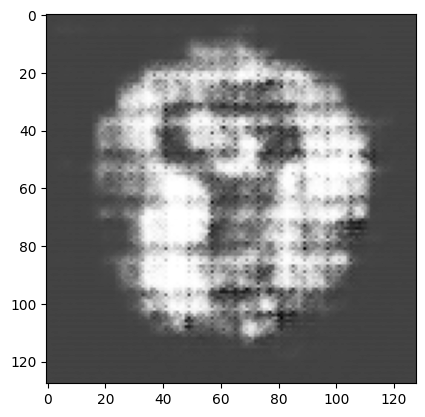

In [ ]:
### Single Image ###
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot

model = load_model('/content/drive/My Drive/Data/Research/Process_2/output/generator_model_430.h5')

vector = asarray([[0.75 for _ in range(100)]])

X = model.predict(vector)

X = (X + 1) / 2.0

pyplot.imshow(X[0, :, :],cmap='gray')
pyplot.show()

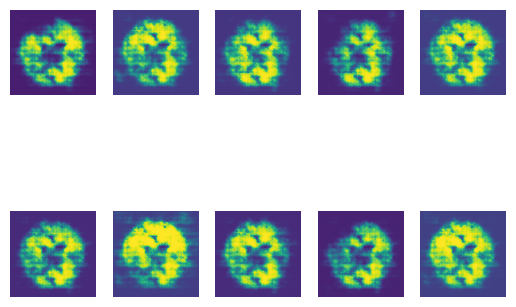

In [ ]:
from matplotlib import pyplot

### Mulitple Images ###

for i in range(10):

 pyplot.subplot(2, 5, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(X[i])

pyplot.show()